In [1]:
import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

from xgboost import XGBClassifier, plot_importance
import shap

import warnings
warnings.filterwarnings('ignore')
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
pd.set_option('display.max_columns', 500)

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
data = pd.read_csv('dataset_2024.csv')
data

,throw_id,team_id,fielder_id,fielder_position,thrower_id,thrower_position,receiver_id,receiver_position,exchange_time,throw_pos_x,throw_pos_y,throw_velo_x,throw_velo_y,throw_velo_z,batter_pos_x_at_throw,batter_pos_y_at_throw,batter_velo_at_throw,bounce_pos_x,bounce_pos_y,bounce_velo_x,bounce_velo_y,bounce_velo_z,receiver_pos_x,receiver_pos_y,receiver_dist_from_1b,throw_deflected_by_receiver,start_state,end_state,runs_on_play,batter_result
0,3,11,400,6,400,6,63,3,1.533,-60.116123,132.187283,60.047557,-33.596364,8.583470,26.912908,26.556102,25.787532,38.061389,69.474629,32.814510,-25.452504,7.330194,56.199323,60.187776,8.202015,0,____1,1___1,0,first
1,6,11,228,5,390,4,63,3,0.534,-0.562563,122.821943,51.293917,-45.316519,8.831870,43.396413,44.290491,28.647878,NaN,NaN,NaN,NaN,NaN,59.013134,65.657938,5.047566,0,1___1,1___2,0,first
2,7,8,415,4,415,4,143,3,1.266,1.598751,123.036931,50.049649,-41.717447,5.986785,25.300783,29.970718,25.130428,NaN,NaN,NaN,NaN,NaN,61.037489,64.429134,2.719261,0,123_1,____3,0,out
3,8,8,308,1,308,1,143,3,1.800,25.403185,59.924587,24.019670,3.289158,12.783662,19.699224,15.249905,18.509230,NaN,NaN,NaN,NaN,NaN,63.142075,65.648720,2.069797,0,____1,____2,0,out
4,10,1,314,4,300,6,514,3,0.733,8.957441,126.165878,51.630666,-63.361730,7.811719,40.118296,41.433396,27.318509,NaN,NaN,NaN,NaN,NaN,59.770395,64.046058,3.890504,0,123_1,____3,0,out
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,33189,1,300,6,187,4,63,3,0.567,-0.706883,127.257516,53.870710,-48.222079,0.569104,43.840928,45.840910,27.057959,56.507357,75.363545,35.754607,-32.706535,8.013511,61.579339,66.498556,3.523959,0,123_1,1_3_2,1,first
19996,33190,1,768,7,768,7,63,3,1.134,-72.726998,241.951358,52.787689,-68.618579,11.903586,31.434120,19.604262,2.305322,50.799574,78.224051,23.266336,-30.850832,11.182392,60.859688,61.483396,3.518128,0,1___0,1___1,0,out
19997,33192,1,63,3,300,6,63,3,1.266,7.741671,124.743019,48.088435,-52.227491,8.389313,40.034865,42.092314,20.951101,NaN,NaN,NaN,NaN,NaN,59.986376,65.275522,4.002790,0,1___1,____3,0,out
19998,33193,15,713,4,713,4,313,3,1.200,65.300092,140.347984,-3.137041,-69.775213,9.328455,34.015906,33.508358,19.628322,NaN,NaN,NaN,NaN,NaN,60.946962,64.565955,2.847538,0,____2,____3,0,out


In [3]:
data.isna().sum()

throw_id                           0
team_id                            0
fielder_id                         0
fielder_position                   0
thrower_id                         0
thrower_position                   0
receiver_id                        0
receiver_position                  0
exchange_time                      7
throw_pos_x                       13
throw_pos_y                       13
throw_velo_x                      12
throw_velo_y                      12
throw_velo_z                      12
batter_pos_x_at_throw             30
batter_pos_y_at_throw             30
batter_velo_at_throw              30
bounce_pos_x                   18109
bounce_pos_y                   18109
bounce_velo_x                  18109
bounce_velo_y                  18109
bounce_velo_z                  18109
receiver_pos_x                    32
receiver_pos_y                    32
receiver_dist_from_1b             32
throw_deflected_by_receiver        0
start_state                        0
e

In [4]:
data = data.dropna(subset=['exchange_time', 'throw_pos_x', 'throw_pos_y', 
                           'throw_velo_x', 'throw_velo_y', 'throw_velo_z', 
                           'batter_pos_x_at_throw', 'batter_pos_y_at_throw',
                           'batter_velo_at_throw','receiver_pos_x', 'receiver_pos_y',
                           'receiver_dist_from_1b']).reset_index(drop=True)
data

,throw_id,team_id,fielder_id,fielder_position,thrower_id,thrower_position,receiver_id,receiver_position,exchange_time,throw_pos_x,throw_pos_y,throw_velo_x,throw_velo_y,throw_velo_z,batter_pos_x_at_throw,batter_pos_y_at_throw,batter_velo_at_throw,bounce_pos_x,bounce_pos_y,bounce_velo_x,bounce_velo_y,bounce_velo_z,receiver_pos_x,receiver_pos_y,receiver_dist_from_1b,throw_deflected_by_receiver,start_state,end_state,runs_on_play,batter_result
0,3,11,400,6,400,6,63,3,1.533,-60.116123,132.187283,60.047557,-33.596364,8.583470,26.912908,26.556102,25.787532,38.061389,69.474629,32.814510,-25.452504,7.330194,56.199323,60.187776,8.202015,0,____1,1___1,0,first
1,6,11,228,5,390,4,63,3,0.534,-0.562563,122.821943,51.293917,-45.316519,8.831870,43.396413,44.290491,28.647878,NaN,NaN,NaN,NaN,NaN,59.013134,65.657938,5.047566,0,1___1,1___2,0,first
2,7,8,415,4,415,4,143,3,1.266,1.598751,123.036931,50.049649,-41.717447,5.986785,25.300783,29.970718,25.130428,NaN,NaN,NaN,NaN,NaN,61.037489,64.429134,2.719261,0,123_1,____3,0,out
3,8,8,308,1,308,1,143,3,1.800,25.403185,59.924587,24.019670,3.289158,12.783662,19.699224,15.249905,18.509230,NaN,NaN,NaN,NaN,NaN,63.142075,65.648720,2.069797,0,____1,____2,0,out
4,10,1,314,4,300,6,514,3,0.733,8.957441,126.165878,51.630666,-63.361730,7.811719,40.118296,41.433396,27.318509,NaN,NaN,NaN,NaN,NaN,59.770395,64.046058,3.890504,0,123_1,____3,0,out
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19920,33189,1,300,6,187,4,63,3,0.567,-0.706883,127.257516,53.870710,-48.222079,0.569104,43.840928,45.840910,27.057959,56.507357,75.363545,35.754607,-32.706535,8.013511,61.579339,66.498556,3.523959,0,123_1,1_3_2,1,first
19921,33190,1,768,7,768,7,63,3,1.134,-72.726998,241.951358,52.787689,-68.618579,11.903586,31.434120,19.604262,2.305322,50.799574,78.224051,23.266336,-30.850832,11.182392,60.859688,61.483396,3.518128,0,1___0,1___1,0,out
19922,33192,1,63,3,300,6,63,3,1.266,7.741671,124.743019,48.088435,-52.227491,8.389313,40.034865,42.092314,20.951101,NaN,NaN,NaN,NaN,NaN,59.986376,65.275522,4.002790,0,1___1,____3,0,out
19923,33193,15,713,4,713,4,313,3,1.200,65.300092,140.347984,-3.137041,-69.775213,9.328455,34.015906,33.508358,19.628322,NaN,NaN,NaN,NaN,NaN,60.946962,64.565955,2.847538,0,____2,____3,0,out


In [5]:
data['thrower_position'].value_counts()

4    6377
6    6367
5    4540
1    1472
9     562
8     271
2     242
7      94
Name: thrower_position, dtype: int64

- Assuming the first base coordinates will (90, 63.64) assuming y coordinate is half the diagonal of the square base

In [6]:
# containing data to throws by infielders and cleaning the data a little bit
data = data[data['thrower_position'].isin([4,5,6])].reset_index(drop=True)
data['throw_dist_from_1b'] = data.apply(lambda x: math.dist([90,63.64],[x['throw_pos_x'],x['throw_pos_y']]), axis=1)
data['throw_velo'] = data.apply(lambda x: np.sqrt(np.square(x['throw_velo_x'])+np.square(x['throw_velo_y'])+np.square(x['throw_velo_z'])), axis=1)
data['batter_dist_at_throw'] = data.apply(lambda x: math.dist([90,63.64],[x['batter_pos_x_at_throw'],x['batter_pos_y_at_throw']]), axis=1)
data['bounce_dist_from_1b'] = data.apply(lambda x: 0.0 if pd.isna(x['bounce_pos_x']) else math.dist([90,63.64],[x['bounce_pos_x'],x['bounce_pos_y']]), axis=1)
data['bounce_velo'] = data.apply(lambda x: 0.0 if pd.isna(x['bounce_velo_x']) else np.sqrt(np.square(x['bounce_velo_x'])+np.square(x['bounce_velo_y'])+np.square(x['bounce_velo_z'])), axis=1)
data['receiver_dist_from_1b'] = data.apply(lambda x: math.dist([90,63.64],[x['receiver_pos_x'],x['receiver_pos_y']]), axis=1) # using my coordinates system for distance as well
data['result'] = data.apply(lambda x: 1 if x['batter_result']=='out' else 0, axis=1)

# dropping columns that are not useful
data = data.drop(columns=['throw_id','team_id','receiver_position','throw_pos_x','throw_pos_y','throw_velo_x','throw_velo_y','throw_velo_z','batter_pos_x_at_throw','batter_pos_y_at_throw','bounce_pos_x','bounce_pos_y','bounce_velo_x','bounce_velo_y','bounce_velo_z','receiver_pos_x','receiver_pos_y','start_state','end_state','runs_on_play','batter_result'])

data

,fielder_id,fielder_position,thrower_id,thrower_position,receiver_id,exchange_time,batter_velo_at_throw,receiver_dist_from_1b,throw_deflected_by_receiver,throw_dist_from_1b,throw_velo,batter_dist_at_throw,bounce_dist_from_1b,bounce_velo,result
0,400,6,400,6,63,1.533,25.787532,33.976516,0,165.026000,69.340470,73.179209,52.265306,42.170532,0
1,228,5,390,4,63,0.534,28.647878,31.052502,0,108.185397,69.011990,50.460854,0.000000,0.000000,0
2,415,4,415,4,143,1.266,25.130428,28.973260,0,106.502471,65.430531,72.935651,0.000000,0.000000,1
3,314,4,300,6,514,0.733,27.318509,30.232332,0,102.359082,82.106379,54.601443,0.000000,0.000000,1
4,312,4,312,4,695,1.200,27.578044,30.378630,0,106.071302,74.944144,54.829966,0.000000,0.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17279,507,5,507,5,63,0.933,28.284878,29.241284,0,111.851370,69.710223,59.113828,0.000000,0.000000,1
17280,300,6,187,4,63,0.567,27.057959,28.564056,0,110.792269,72.303155,49.471887,35.485189,49.115433,0
17281,63,3,300,6,63,1.266,20.951101,30.058153,0,102.469565,71.488384,54.413394,0.000000,0.000000,1
17282,713,4,713,4,313,1.200,19.628322,29.067790,0,80.586601,70.465888,63.577784,0.000000,0.000000,1


In [7]:
data['result'].value_counts()

1    15286
0     1998
Name: result, dtype: int64

In [8]:
display(data.corr())
def high_corr_pairs(df, threshold=0.8):
    """
    Identify pairs of variables in a DataFrame that have a correlation coefficient above a specified threshold.
    
    Parameters:
    - df (DataFrame): The input data.
    - threshold (float, optional): The correlation coefficient threshold. Defaults to 0.8.
    
    Returns:
    - list of tuples: Pairs of column names with high correlation.
    """
    corr_matrix = df.corr().abs()

    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    
    pairs = []
    for column in to_drop:
        above_threshold_vars = upper.index[upper[column] > threshold].tolist()
        for atv in above_threshold_vars:
            pairs.append((column, atv,upper[column][atv]))

    return pairs

high_corr_pairs(data, threshold=0.5)

,fielder_id,fielder_position,thrower_id,thrower_position,receiver_id,exchange_time,batter_velo_at_throw,receiver_dist_from_1b,throw_deflected_by_receiver,throw_dist_from_1b,throw_velo,batter_dist_at_throw,bounce_dist_from_1b,bounce_velo,result
fielder_id,1.000000,0.103035,0.893048,0.087608,0.039313,0.009185,-0.010702,0.020333,0.015686,0.026583,0.077627,0.013090,-0.004994,-0.004294,-0.008344
fielder_position,0.103035,1.000000,0.069444,0.642583,0.000578,0.086175,-0.155622,0.275625,0.039819,0.419466,0.236130,0.208784,0.089434,0.078487,-0.127494
thrower_id,0.893048,0.069444,1.000000,0.121634,0.032290,0.014890,0.003588,-0.004200,0.014272,0.025153,0.086052,0.007702,-0.005373,-0.004615,0.006225
thrower_position,0.087608,0.642583,0.121634,1.000000,-0.002691,0.031002,0.087559,0.021822,0.042067,0.496954,0.414245,0.105125,0.105307,0.096508,-0.033960
receiver_id,0.039313,0.000578,0.032290,-0.002691,1.000000,0.016456,-0.002621,0.001267,-0.004012,-0.002574,0.019509,0.002143,-0.009005,-0.009978,0.006361
exchange_time,0.009185,0.086175,0.014890,0.031002,0.016456,1.000000,-0.443425,0.214131,-0.043691,0.096121,-0.085030,0.252295,-0.049850,-0.057862,0.105994
batter_velo_at_throw,-0.010702,-0.155622,0.003588,0.087559,-0.002621,-0.443425,1.000000,-0.493008,0.041413,0.064647,0.402485,-0.421015,0.038807,0.067504,-0.007528
receiver_dist_from_1b,0.020333,0.275625,-0.004200,0.021822,0.001267,0.214131,-0.493008,1.000000,0.004791,0.080171,-0.230416,0.158390,0.027287,-0.005437,-0.239389
throw_deflected_by_receiver,0.015686,0.039819,0.014272,0.042067,-0.004012,-0.043691,0.041413,0.004791,1.000000,0.086954,0.042561,0.000563,0.238160,0.288335,-0.382499
throw_dist_from_1b,0.026583,0.419466,0.025153,0.496954,-0.002574,0.096121,0.064647,0.080171,0.086954,1.000000,0.598357,0.352163,0.292715,0.265072,-0.106497


[('thrower_id', 'fielder_id', 0.8930475407032974),
 ('thrower_position', 'fielder_position', 0.6425827506984861),
 ('throw_velo', 'throw_dist_from_1b', 0.598356909249912),
 ('bounce_velo', 'bounce_dist_from_1b', 0.9362870212421743)]

In [9]:
X = data.loc[:,['fielder_position','thrower_position','exchange_time','batter_velo_at_throw',
                'receiver_dist_from_1b', 'throw_deflected_by_receiver','throw_dist_from_1b', 
                'throw_velo', 'batter_dist_at_throw', 'bounce_dist_from_1b']]
y = data['result'].values

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

In [10]:
logreg_model = LogisticRegression()
lst_accu_stratified = []
  
for train_index, test_index in skf.split(X, y):
    x_train_fold, x_test_fold = X.loc[train_index,:], X.loc[test_index,:]
    y_train_fold, y_test_fold = y[train_index], y[test_index]
    logreg_model.fit(x_train_fold, y_train_fold)
    lst_accu_stratified.append(logreg_model.score(x_test_fold, y_test_fold))

print(np.mean(lst_accu_stratified))

0.9150656422038003


In [11]:
logreg_model.coef_

array([[-0.18585132,  0.05726445,  1.490134  , -0.05023758, -0.12191618,
        -3.56457904, -0.02529938,  0.0519906 ,  0.09193143, -0.0380306 ]])

In [12]:
logreg_model.intercept_

array([0.37904136])

In [13]:
rf_model = RandomForestClassifier()
rf_accu_stratified = []
  
for train_index, test_index in skf.split(X, y):
    x_train_fold, x_test_fold = X.loc[train_index,:], X.loc[test_index,:]
    y_train_fold, y_test_fold = y[train_index], y[test_index]
    rf_model.fit(x_train_fold, y_train_fold)
    rf_accu_stratified.append(rf_model.score(x_test_fold, y_test_fold))

print(np.mean(rf_accu_stratified))

0.9638390848917165


<Axes: >

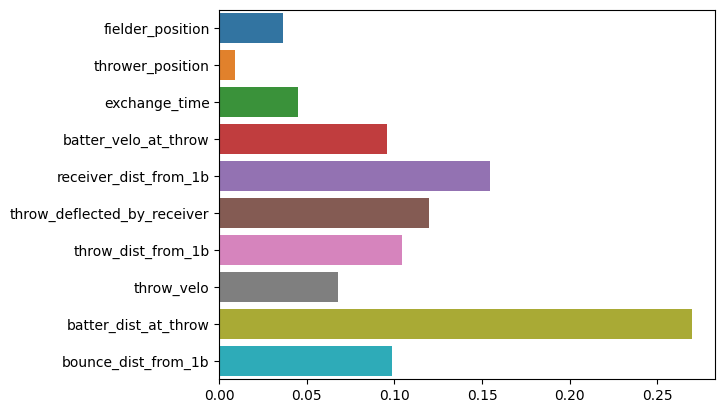

In [14]:
sns.barplot(x=rf_model.feature_importances_,y=X.columns)

In [15]:
xgb_model = XGBClassifier()
xgb_accu_stratified = []
  
for train_index, test_index in skf.split(X, y):
    x_train_fold, x_test_fold = X.loc[train_index,:], X.loc[test_index,:]
    y_train_fold, y_test_fold = y[train_index], y[test_index]
    xgb_model.fit(x_train_fold, y_train_fold)
    xgb_accu_stratified.append(xgb_model.score(x_test_fold, y_test_fold))

print(np.mean(xgb_accu_stratified))
print(confusion_matrix(y_test_fold,xgb_model.predict(x_test_fold)))

0.9671370600646917
[[ 165   34]
 [  24 1505]]


In [16]:
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X)

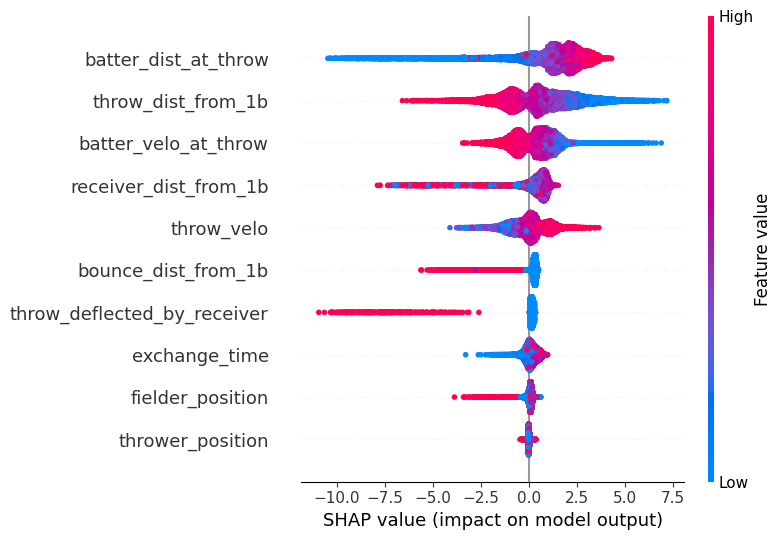

In [17]:
shap.summary_plot(shap_values, X)

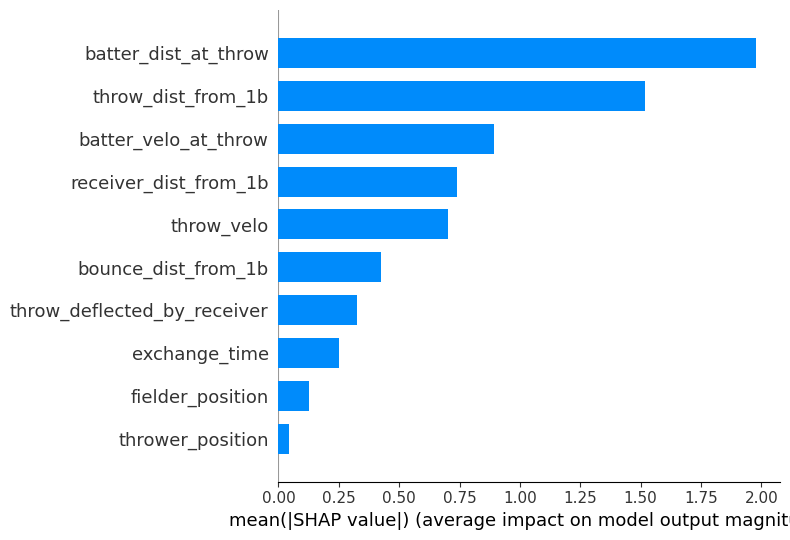

In [18]:
shap.summary_plot(shap_values, X, plot_type='bar')

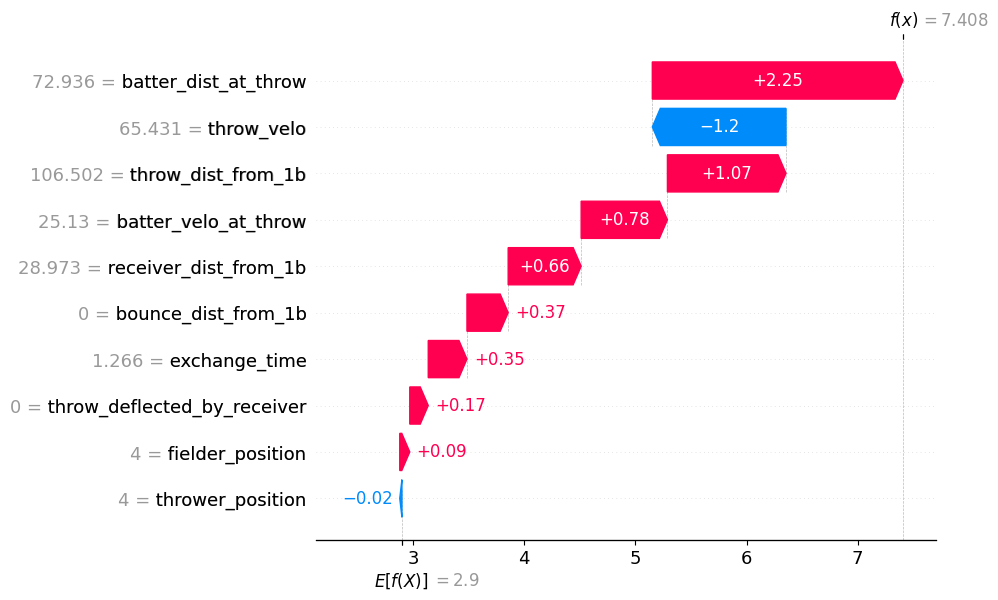

In [19]:
shap_values = explainer(X)
shap.plots.waterfall(shap_values[2,:])

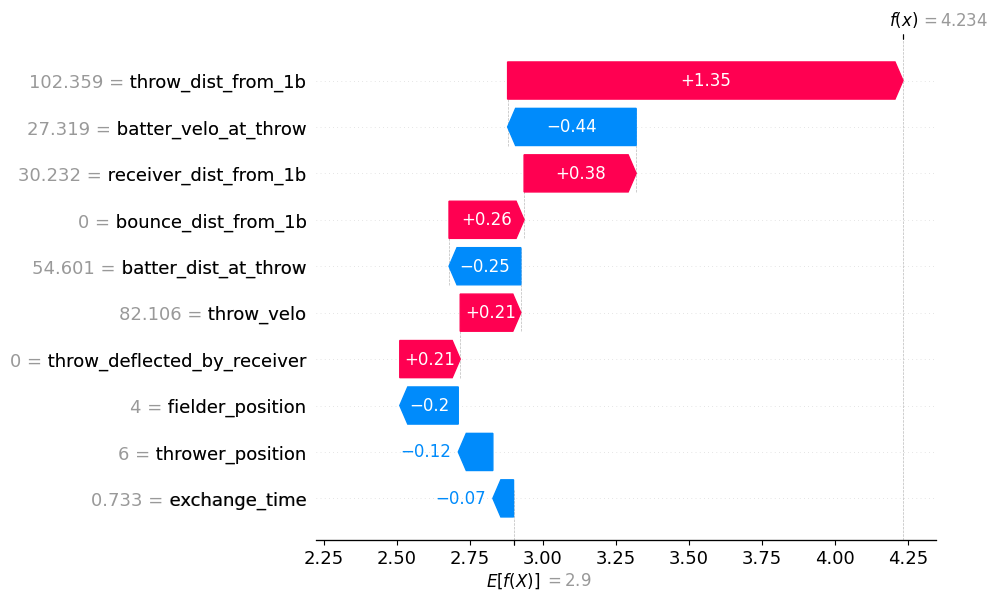

In [20]:
shap.plots.waterfall(shap_values[3,:])

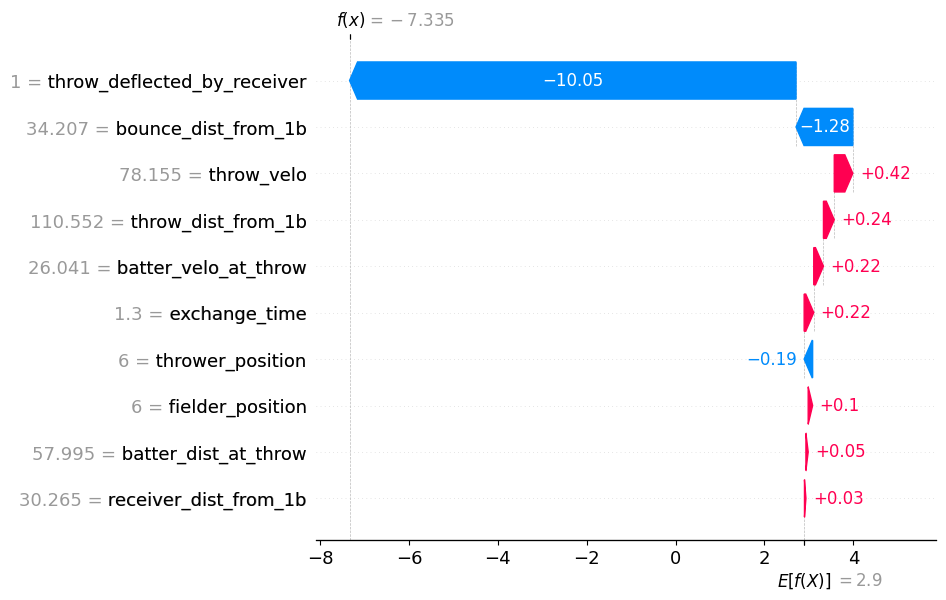

In [21]:
shap.plots.waterfall(shap_values[10,:])